<a href="https://colab.research.google.com/github/JOTOR/Examples_Python/blob/master/SHAP_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SHAP (SHapley Additive exPlanations) Overview**<br>
*A Python library for ML explainability*<br><br>
Created by: Jhonnatan Torres <br>
Last Updated on: May 3rd of 2021

*The goal of this notebook is to analize this library from a **coding** perspective, highlighting the capabilities, available plots and possible disadvantages*
___

## **Background**

>   *The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. A player can be an individual feature value, e.g. for tabular data. A player can also be a group of feature values. For example to explain an image, pixels can be grouped to super pixels and the prediction distributed among them. One innovation that SHAP brings to the table is that the Shapley value explanation is represented as an additive feature attribution method, a linear model*

Extracted from: https://christophm.github.io/interpretable-ml-book/shap.html#definition


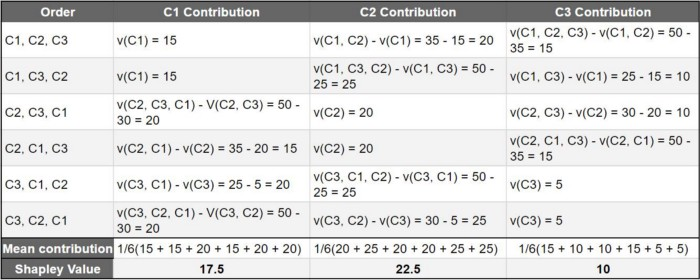

Extracted from: https://medium.com/@kalia_65609/interpreting-an-nlp-model-with-lime-and-shap-834ccfa124e4

____

Importing required libraries

In [ ]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from collections import Counter
import matplotlib.pyplot as plt
np.random.seed(1234)

In [ ]:
#Installing shap
!pip install shap --upgrade

Requirement already up-to-date: shap in /usr/local/lib/python3.7/dist-packages (0.39.0)


In [ ]:
import shap

## **Classification Examples (Tabular)**

The documentation provides examples using that require a few or none preprocessing steps, we know thos kind of datasets are not common, for simplicity and at least for these Classification Examples, I am going to use the famous titanic dataset which contains a mix of categorical and numerical features and it also contains null or blank records

In [ ]:
#Following sklearn example in order to fetch the data from openml
# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

#preprocessing pipeline
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=False)),
    ('ohe', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
X.head()

pclass  ...                        home.dest
0     1.0  ...                     St Louis, MO
1     1.0  ...  Montreal, PQ / Chesterville, ON
2     1.0  ...  Montreal, PQ / Chesterville, ON
3     1.0  ...  Montreal, PQ / Chesterville, ON
4     1.0  ...  Montreal, PQ / Chesterville, ON

[5 rows x 13 columns]

SHAP library only support an estimator or model as a input, therefore it is not possible to use pipelines, however, you can create a pipeline for all the preprocessing steps, transform the datasets and provide the model and transformed dataset as arguments for the *explainer*

In [ ]:
#splitting and transforming the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234, stratify=y)

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

print(X_train_trans.shape)
print(X_test_trans.shape)

(916, 8)
(393, 8)


In [ ]:
#Defining a very basic model for the classification
tree = DecisionTreeClassifier(max_depth=3, random_state=1234)

In [ ]:
#fitting the estimator
tree.fit(X_train_trans, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

In [ ]:
#getting the predictions and scores
predictions = tree.predict(X_test_trans)
print(tree.score(X_train_trans, y_train))
print(tree.score(X_test_trans, y_test))

0.8176855895196506
0.7811704834605598


In [ ]:
#Utility function to get the feature names from the data preprocessing pipeline
#https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
# Function provided by Johannes Haupt
def get_feature_names(column_transformer):
    import warnings
    import sklearn
    import pandas as pd
    import numpy as np
    def get_names(trans):
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    feature_names = []

    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        l_transformers = list(column_transformer._iter(fitted=True))

    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            _names = get_feature_names(trans)
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [ ]:
names = get_feature_names(preprocessor)
print(names)

['num__age', 'num__fare', 'ohe__x0_Q', 'ohe__x0_S', 'ohe__x0_missing_value', 'ohe__x1_male', 'ohe__x2_2.0', 'ohe__x2_3.0']


Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


In [ ]:
#SHAP explainer requires the feature name but these were removed by the preprocessing pipeline.
#Using the get_feature_names is possible to build a couple of dataframes with the preprocessed data
# and the feature names
X_train_trans_pd = pd.DataFrame(X_train_trans, columns=names)
X_test_trans_pd = pd.DataFrame(X_test_trans, columns=names)

Calculating SHAP values from the Explainer

In [ ]:
explainer = shap.TreeExplainer(tree, X_train_trans_pd)
tree_shap_values = explainer.shap_values(X_test_trans_pd)

In [ ]:
#data structure of the shap values
tree_shap_values[0][0]

array([ 0.03250264,  0.02585918,  0.        ,  0.        ,  0.        ,
        0.25335446,  0.        , -0.03657746])

### **Force Plots**

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], tree_shap_values[1][25], X_test_trans_pd.iloc[25,:], link='identity')
#current plot is providing the predicted probability, you can get the "logit" by replacing link="logit"

Force Plot for the 25th observation of the test dataset and for the class **Survived = 1**, it could be inferred the *survival* was influenced for Male=0 and Class=1 or 2

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], tree_shap_values[1], X_test_trans_pd, link='identity')

### **Decision Plot**

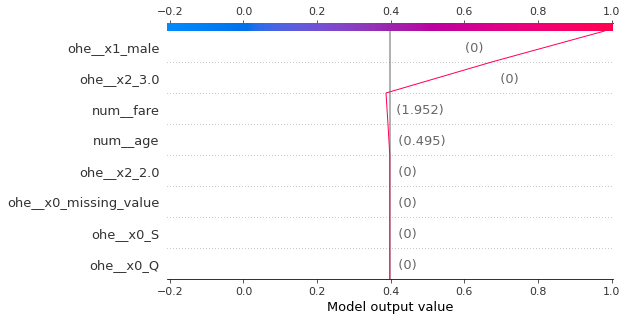

In [ ]:
shap.decision_plot(base_value=explainer.expected_value[1], shap_values=tree_shap_values[1][25], features=X_test_trans_pd.iloc[25,:])

With the decision plot, we can confirm this individual was a Female from 1st Class, those were the values of the features with the highest influence over the prediction

### **Overall Summary Plot**

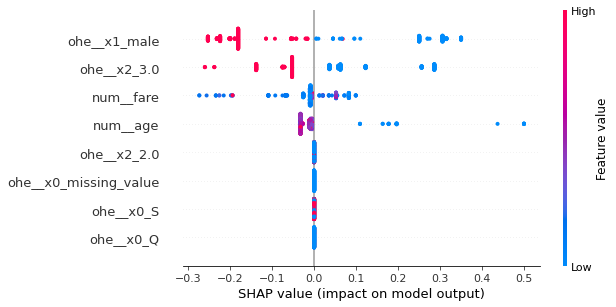

In [ ]:
shap.summary_plot(tree_shap_values[1], X_test_trans_pd, plot_type='dot')

This plot is really handy to explain the features with the highest influence or importance in the model and the effect of the feature values over the prediction:<br>

The "Survival" probability of Gender = **Male**, Class = **3**, Class = **2** passengers is small

### **Overall Decision Plot**

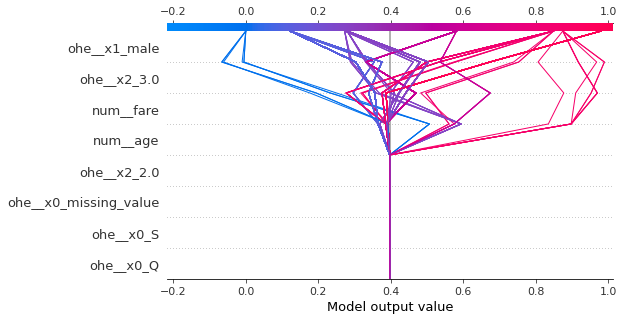

In [ ]:
shap.decision_plot(base_value=explainer.expected_value[1], shap_values=tree_shap_values[1], features=X_test_trans_pd)

With this plot you can visualize all the "predictions paths", it can be handy to analyze if there is a bias in the dataset or diagnose the predictions of the estimator

### **Explaining a more complex estimator**

In [ ]:
 estimators = [
               ('rf', RandomForestClassifier(n_estimators=3, max_depth=3, random_state=1234)),
               ('tree', DecisionTreeClassifier(max_depth=5, random_state=1234)),
               ('nb', BernoulliNB())
              ]

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=0.8, max_iter=250, random_state=1234))

In [ ]:
#fitting a stacking classifier
clf.fit(X_train_trans, y_train)

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=3,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                        

In [ ]:
#Quick diagnosis of the complex estimator
print(clf.predict_proba([X_test_trans_pd.iloc[25,:]]))
print("Basic Tree:")
print(Counter(clf.predict(X_test_trans_pd)))
print("Stacking")
print(Counter(tree.predict(X_test_trans_pd)))
print(clf.score(X_train_trans_pd, y_train))
print(clf.score(X_test_trans_pd, y_test))

[[0.08683407 0.91316593]]
Basic Tree:
Counter({'0': 263, '1': 130})
Stacking
Counter({'0': 263, '1': 130})
0.8329694323144105
0.8015267175572519


**Explainer** or **TreeExplainer** do not work with this complex estimator (Tree+Naive+Linear), SHAP provides a **KernelExplainer** that according to the library documentation:
  >*Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model.*

In [ ]:
X_train_trans_pd_sample = shap.sample(X_train_trans_pd, 250)
X_test_trans_pd_sample = shap.sample(X_test_trans_pd, 50)

In [ ]:
xlp = shap.KernelExplainer(clf.predict_proba, X_train_trans_pd_sample, link='identity')

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
xlp_shap = xlp.shap_values(X_test_trans_pd_sample)

You can calculate shap values for specific, single predictions (*faster*) or for the entire test dataset (*slower*), in my case, I am going to provide an overall summary plot therefore I need these values for a sample of the test dataset

In [ ]:
shap.initjs()
shap.force_plot(xlp.expected_value[1], xlp_shap[1][2], X_test_trans_pd_sample.iloc[2,:])

In [ ]:
print(clf.predict([X_test_trans_pd_sample.iloc[2,:]]))

['1']


In [ ]:
shap.initjs()
shap.force_plot(xlp.expected_value[1], xlp_shap[1], X_test_trans_pd_sample)

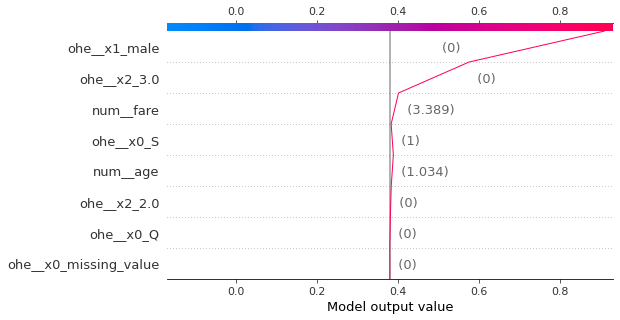

In [ ]:
shap.decision_plot(base_value=xlp.expected_value[1], shap_values=xlp_shap[1][2], features=X_test_trans_pd.iloc[2,:])

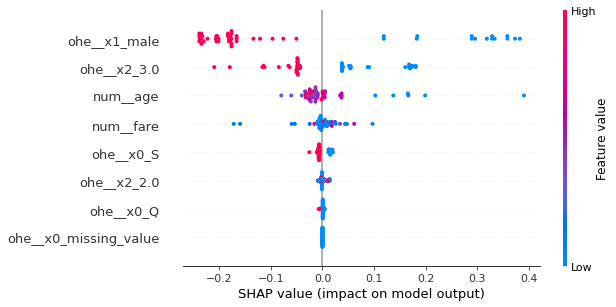

In [ ]:
shap.summary_plot(xlp_shap[1], X_test_trans_pd_sample, plot_type='dot', title="SHAP Values by Feature and Class = 1")

## **Regression Example**

For the regression section, I am going to use a built in dataset, that requires few or none preprocessing steps

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(load_boston()['data'], load_boston()['target'], test_size=0.3, random_state=1234)

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_b = pd.DataFrame(data = scaler.fit_transform(X_train_b), columns=load_boston()['feature_names'])
X_test_b = pd.DataFrame(data=scaler.transform(X_test_b), columns=load_boston()['feature_names'])

In [ ]:
X_train_b.head(2)

CRIM        ZN     INDUS  ...   PTRATIO         B     LSTAT
0 -0.392361 -0.464484 -1.233419  ... -0.216976  0.455463 -0.914807
1 -0.372811 -0.464484 -0.388974  ...  1.126494 -2.996480 -0.282885

[2 rows x 13 columns]

In [ ]:
X_test_b.head(2)

CRIM        ZN     INDUS  ...   PTRATIO        B     LSTAT
0 -0.398353  0.304690 -1.458307  ...  0.060984  0.41672 -0.650083
1 -0.382588 -0.464484 -0.388974  ...  1.126494  0.43281 -0.455098

[2 rows x 13 columns]

In [ ]:
reg = Ridge(random_state=1234)

In [ ]:
reg.fit(X_train_b, y_train_b)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1234, solver='auto', tol=0.001)

In [ ]:
#Quick diagnosis of the model
from sklearn.metrics import mean_squared_error
reg_preds = reg.predict(X_test_b)
np.sqrt(mean_squared_error(y_test_b, reg_preds))

4.894683639005903

In [ ]:
reg_xlp = shap.LinearExplainer(reg, X_train_b)

In [ ]:
reg_xlp_shap_values = reg_xlp.shap_values(X_test_b)

### **Force Plot**

In [ ]:
print(reg.predict([X_test_b.iloc[5,:]]))
shap.initjs()
shap.force_plot(reg_xlp.expected_value, reg_xlp_shap_values[5], X_test_b.iloc[5,:])

[27.47628088]


What about the **matplotlib** output instead of the default **javascript**?

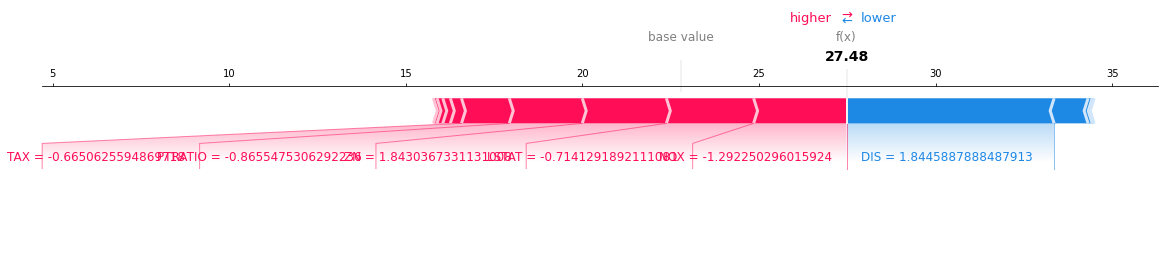

In [ ]:
shap.force_plot(reg_xlp.expected_value, reg_xlp_shap_values[5], X_test_b.iloc[5,:], matplotlib=True)

In [ ]:
shap.initjs()
shap.force_plot(reg_xlp.expected_value, reg_xlp_shap_values, X_test_b)

### **Decision Plot**

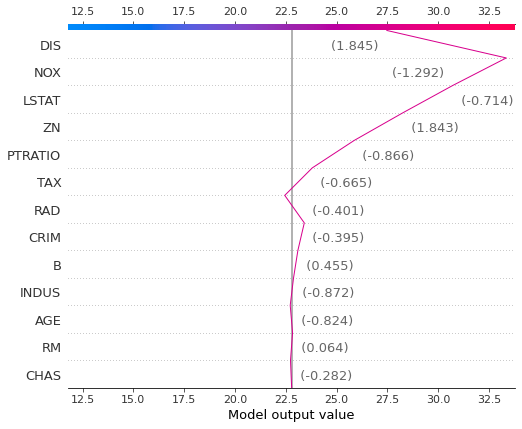

In [ ]:
shap.decision_plot(base_value=reg_xlp.expected_value, shap_values=reg_xlp_shap_values[5], features=X_test_b.iloc[5,:])

### **Overall Summary Plot**

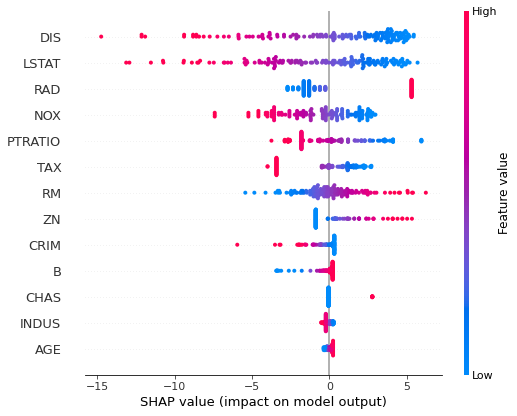

In [ ]:
shap.initjs()
shap.summary_plot(reg_xlp_shap_values, X_test_b)

## **Clustering Example**

Documentation is not clear about if unsupervised classifiers / estimators are supported

In [ ]:
from sklearn.datasets import load_iris
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(load_iris()['data'], load_iris()['target'], test_size=0.3, 
                                                            random_state=1234, stratify=load_iris()['target'])

In [ ]:
X_train_i = pd.DataFrame(X_train_i, columns=load_iris()['feature_names'])
X_test_i = pd.DataFrame(X_test_i, columns=load_iris()['feature_names'])

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
km = KMeans(n_clusters=3, random_state=1234)

In [ ]:
km.fit(X_train_i)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [ ]:
km_xlp = shap.KernelExplainer(km.predict, X_train_i, link='identity')

Using 105 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
km_xlp_shap = km_xlp.shap_values(X_test_i)

### **Force Plot**

In [ ]:
shap.initjs()
shap.force_plot(km_xlp.expected_value, km_xlp_shap[7], X_test_i.iloc[7,:])

In [ ]:
km.predict(X_test_i)

array([2, 2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2,
       0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 1, 0,
       0], dtype=int32)

### **Overall Force Plot**

In [ ]:
shap.initjs()
shap.force_plot(km_xlp.expected_value, km_xlp_shap, X_test_i)

In [ ]:
iris_test = pd.concat([X_test_i, pd.Series(y_test_i), pd.Series(km.predict(X_test_i))],axis=1)
iris_test.columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)','target', 'cluster_k']

In [ ]:
iris_test['diff'] = np.where(iris_test['cluster_k']!=iris_test['target'],"red","white")

In [ ]:
iris_test.head(5)

sepal length (cm)  sepal width (cm)  ...  cluster_k   diff
0                6.7               3.0  ...          2  white
1                6.8               3.0  ...          2  white
2                6.3               3.4  ...          2  white
3                4.4               3.0  ...          0  white
4                6.3               3.3  ...          2  white

[5 rows x 7 columns]

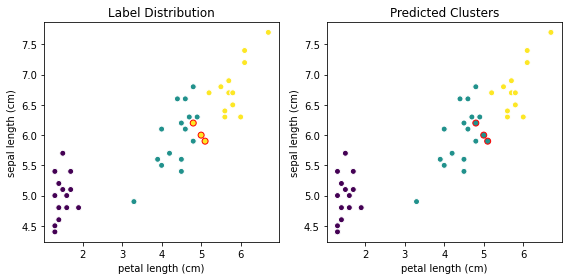

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(iris_test['petal length (cm)'], iris_test['sepal length (cm)'], c=iris_test['target'],edgecolors=iris_test['diff'])
plt.xlabel('petal length (cm)')
plt.ylabel('sepal length (cm)')
plt.title('Label Distribution')
plt.subplot(1,2,2)
plt.scatter(iris_test['petal length (cm)'], iris_test['sepal length (cm)'], c=iris_test['cluster_k'], edgecolors=iris_test['diff'])
plt.xlabel('petal length (cm)')
plt.ylabel('sepal length (cm)')
plt.title('Predicted Clusters')
plt.tight_layout()

In [ ]:
to_explain = iris_test[iris_test['diff']=='red'].drop(columns=['cluster_k', 'target', 'diff']).iloc[1,:]
print(to_explain)

sepal length (cm)    5.9
sepal width (cm)     3.0
petal length (cm)    5.1
petal width (cm)     1.8
Name: 30, dtype: float64


In [ ]:
shap.initjs()
inc_shap = km_xlp.shap_values(to_explain)
print(km.predict([to_explain]))
shap.force_plot(km_xlp.expected_value, inc_shap, to_explain)

[1]


## **More Advanced Examples**

### **Transformers Pipelines**

In [ ]:
!pip install transformers

In [ ]:
import transformers

In [ ]:
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

In [ ]:
model(["What a great support and service", "That guy at the phone did not pay attention and did not resolve my issue"])

[[{'label': 'NEGATIVE', 'score': 0.0001369170204270631},
  {'label': 'POSITIVE', 'score': 0.9998630881309509}],
 [{'label': 'NEGATIVE', 'score': 0.9997777938842773},
  {'label': 'POSITIVE', 'score': 0.00022221951803658158}]]

In [ ]:
t_xlp = shap.Explainer(model)
shap_values = t_xlp(["What a great support and service", "That guy at the phone did not pay attention and did not resolve my issue"])

In [ ]:
shap.plots.text(shap_values[0, :, "POSITIVE"])

In [ ]:
1/(1+np.exp(8.896 * -1))

0.9998630831740287

In [ ]:
shap.plots.text(shap_values[1, :, "POSITIVE"])

In [ ]:
1/(1+np.exp(-8.4116 * -1))

0.00022222453923955476

In [ ]:
zero = transformers.pipeline("zero-shot-classification")

In [ ]:
text_class = ['After 12 years of left-wing influence in Ecuador, people decided to change and chose the right wing candidate in the most recent elections',
        'Real Madrid is facing Chelsea in the UEFA Champions League semi finals']
candidate_labels = ['sports', 'politics']

In [ ]:
zero(text_class, candidate_labels)

[{'labels': ['politics', 'sports'],
  'scores': [0.9852885603904724, 0.014711452648043633],
  'sequence': 'After 12 years of left-wing influence in Ecuador, people decided to change and chose the right wing candidate in the most recent elections'},
 {'labels': ['sports', 'politics'],
  'scores': [0.9914246201515198, 0.00857536680996418],
  'sequence': 'Real Madrid is facing Chelsea in the UEFA Champions League semi finals'}]

In [ ]:
try: 
  zero_xlp = shap.Explainer(zero)
  zero_shap_values = zero_xlp(text_class, candidate_labels)
except:print("Error")

Error


Following the same steps with a different pipeline did not work

### **Fashion MNIST**

Adjusted from the digits MNIST example referenced in the library documentation

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
(training_images, training_labels), (test_images, test_labels) = mnist

In [ ]:
training_images = training_images.reshape(training_images.shape[0], 28, 28, 1)
training_images = training_images/255

In [ ]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
test_images = test_images / 255

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
tf.keras.layers.MaxPooling2D((2,2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(training_images, training_labels, epochs=5, validation_data=(test_images, test_labels), batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.6841 - accuracy: 0.7543 - val_loss: 0.3798 - val_accuracy: 0.8637
Epoch 2/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.3210 - accuracy: 0.8843 - val_loss: 0.3174 - val_accuracy: 0.8824
Epoch 3/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2753 - accuracy: 0.8984 - val_loss: 0.3137 - val_accuracy: 0.8854
Epoch 4/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2437 - accuracy: 0.9089 - val_loss: 0.2749 - val_accuracy: 0.8983
Epoch 5/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2154 - accuracy: 0.9207 - val_loss: 0.2804 - val_accuracy: 0.8999


In [ ]:
background = training_images[np.random.choice(training_images.shape[0], 100, replace=False)]

In [ ]:
background.shape

(100, 28, 28, 1)

In [ ]:
fmnist = shap.DeepExplainer(model, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [ ]:
fmnist_shap_values = fmnist.shap_values(test_images[10:20])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


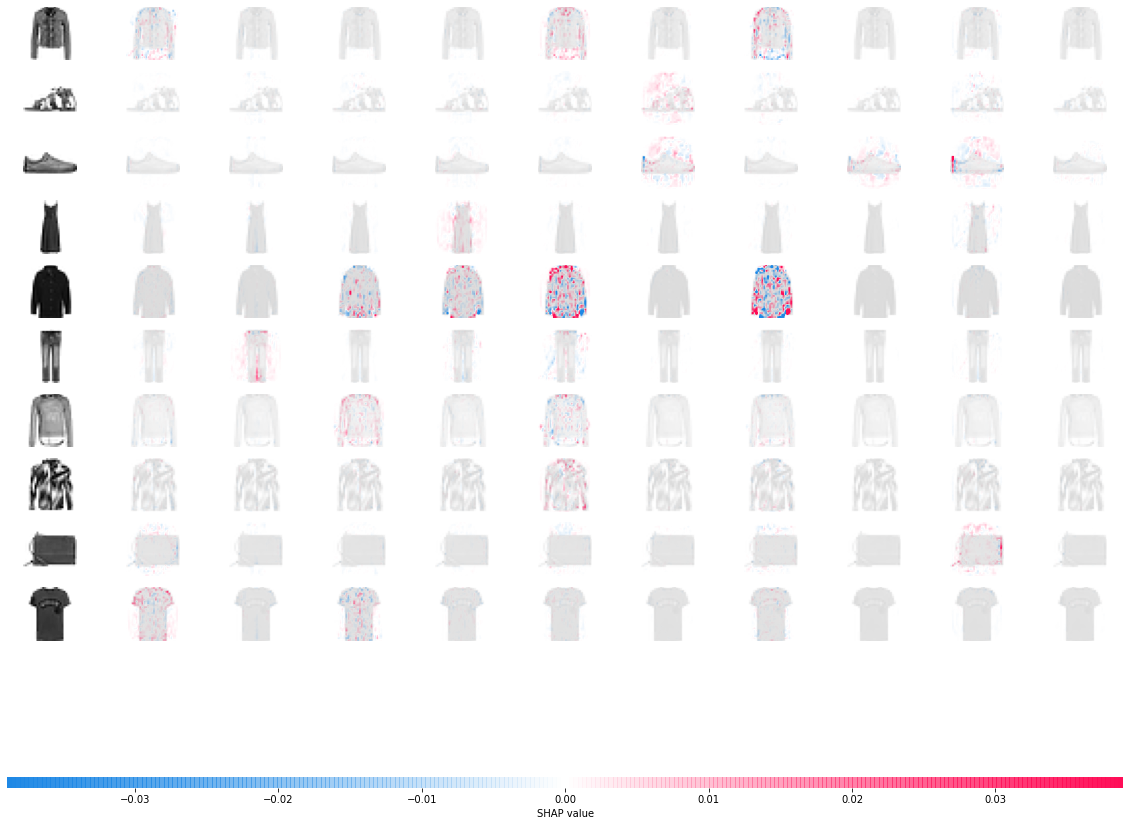

In [ ]:
shap.image_plot(fmnist_shap_values, -test_images[10:20])

In [ ]:
model_preds = np.argmax(model.predict(test_images),axis=1)

In [ ]:
#Quick Model Diagnosis
from sklearn.metrics import classification_report
print(classification_report(test_labels, model_preds))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.98      0.98      0.98      1000
           2       0.82      0.85      0.83      1000
           3       0.86      0.94      0.90      1000
           4       0.80      0.88      0.84      1000
           5       0.96      0.98      0.97      1000
           6       0.84      0.61      0.71      1000
           7       0.96      0.94      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## **Disadvantages / Drawbacks**

### **Persistence**

As you could observe, a trained explainer is required to provide explanations over new inferences, however, in the documentation there are not references about the **persistence** or how to save and reuse these explainers

In [ ]:
names = ['Tree_Explainer', 'Stacking', 'Regression', 'Transformer', 'Fashion_MNIST', 'Clustering']
explainers = [explainer, xlp, reg_xlp, t_xlp, fmnist, km_xlp]

In [ ]:
import pickle
for name, expl in zip(names, explainers):
  try:
    print("Explainer Name: ", name)
    pickle.dump(expl, open(name+'.pkl', 'wb'))
    print("Explainer"+"["+name+']'+" has been saved to Pickle")
  except: 
    print("Problem with explainer: ", expl, " ")
    continue

Explainer Name:  Tree_Explainer
Explainer[Tree_Explainer] has been saved to Pickle
Explainer Name:  Stacking
Problem with explainer:  <shap.explainers._kernel.Kernel object at 0x7f66dbcea490>  
Explainer Name:  Regression
Explainer[Regression] has been saved to Pickle
Explainer Name:  Transformer
Explainer[Transformer] has been saved to Pickle
Explainer Name:  Fashion_MNIST
Problem with explainer:  <shap.explainers._deep.Deep object at 0x7f66d11fd190>  
Explainer Name:  Clustering
Explainer[Clustering] has been saved to Pickle


In [ ]:
!ls

Clustering.pkl	  Fashion_MNIST.pkl  Stacking.pkl
cp_fmnist.pkl	  Regression.pkl     Transformer.pkl
cp_stack_clf.pkl  sample_data	     Tree_Explainer.pkl


In [ ]:
saved_km = pickle.load(open('/content/Clustering.pkl', 'rb'))

In [ ]:
print(saved_km.shap_values(to_explain))
print(saved_km.expected_value)

[-0.17619048 -0.01269841  0.28095238 -0.01587302]
0.9238095238095239


May 3rd of 2021 update, using [**Cloudpickle**](https://github.com/cloudpipe/cloudpickle) to save and reuse the explainers, as it was suggested by [Simon P.](https://github.com/simon-price)

In [ ]:
!pip install cloudpickle --upgrade

Requirement already up-to-date: cloudpickle in /usr/local/lib/python3.7/dist-packages (1.6.0)


In [ ]:
import cloudpickle

In [ ]:
pickled_stacked_clf = cloudpickle.dump(xlp, open('cp_stack_clf.pkl', 'wb'))

In [ ]:
!ls

Clustering.pkl	  Fashion_MNIST.pkl  Stacking.pkl
cp_fmnist.pkl	  Regression.pkl     Transformer.pkl
cp_stack_clf.pkl  sample_data	     Tree_Explainer.pkl


In [ ]:
saved_stack_clf_xlp = cloudpickle.load(open('/content/cp_stack_clf.pkl', 'rb'))

In [ ]:
print(saved_stack_clf_xlp.shap_values(X_test_trans_pd_sample.iloc[2,:])[1])
print(saved_stack_clf_xlp.expected_value[1])

[ 0.0052248   0.01810914  0.00144472 -0.00542321  0.          0.33387623
  0.00218143  0.17423296]
0.3802824713443077


In [ ]:
#Deepexplainer could not be saved
try:
  cloudpickle.dump(fmnist, open('cp_fmnist.pkl', 'wb'))
except: print("error")

error


There is not a unique method to save these explainers to a Pickle, H5 or an own file format and reuse them for later inferences or explanations

### **Others**



*   Transformer Pipeline for *Zero Shot Classification* is not supported
*   Most interesting plots are in a JavaScript format / output
*   Entire Sklearn ML Pipelines are not supported
*   It is not clear in the library documentation if unsupervised estimators are supported
*   In theory, the transformations applied from the sklearn.preproccesing modules should be reversed in order to get the original magnitude of the features
*   Two documentation sources (I prefer Github) with some disconnections, for example:<br>
https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Front%20Page%20DeepExplainer%20MNIST%20Example.html<br><br>
https://slundberg.github.io/shap/notebooks/deep_explainer/Front%20Page%20DeepExplainer%20MNIST%20Example.html

*   For NLP tasks, if an embedding or encoding was used, you have to reverse it in order to assign or include the *feature names*



## **References**



*   https://github.com/slundberg/shap [Oficial Documentation]
*   https://shap.readthedocs.io/en/latest/index.html [Oficial Documentation]
*   https://www.youtube.com/watch?v=0yXtdkIL3Xk [PyData Tel Aviv Meetup: SHAP Values for ML Explainability - Adi Watzman]
*   https://christophm.github.io/interpretable-ml-book/agnostic.html [Interpretable Machine Learning]
*   https://medium.com/@kalia_65609/interpreting-an-nlp-model-with-lime-and-shap-834ccfa124e4 [Medium Post about SHAP and LIME]
*   https://github.com/marcotcr/lime [Related work in ML explainability]
*   https://cran.r-project.org/web/packages/shapr/vignettes/understanding_shapr.html [SHAP Library for R Language]

